In [ ]:
#default_exp audio.augment
#default_cls_lvl 3

# Data Augmentation for Audio

> Transforms to apply data augmentation to AudioSpectrograms and Signals

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *

In [ ]:
# export
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli
from librosa.effects import split
from dataclasses import asdict
import librosa

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
x = AudioGetter("", recurse=True, folders=None)
files = x(p)
aud = AudioItem.create(files[0])

In [ ]:
cfg = {"n_fft":2560}
to_spectrogram = AudioToSpec(cfg)

In [ ]:
original_spec = to_spectrogram(aud)

In [ ]:
original_spec.show()

## Spectrogram Transforms

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> 
<li> Write tfm_pad_spectro for the case where the crop window is bigger than the original sg and it needs to be padded </li></ul>
</div>

###  Crop Time, pad_spectro(internal)

In [ ]:
#export
def CropTime(duration, sr, hop, pad_mode="zeros"):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Random crops full spectrogram to be length specified in ms by crop_duration'''
        sg = spectro.clone()
        w_crop = int((sr*duration)/(1000*hop))
        w_sg   = sg.shape[-1]
        if   w_sg <  w_crop: return _tfm_pad_spectro(sg, w_crop, pad_mode=pad_mode)
        elif w_sg == w_crop: return sg
        else:
            crop_start = random.randint(0, int(w_sg - w_crop))
            sg_crop = sg[:,:,crop_start:crop_start+w_crop]
            sg_crop.sample_start = int(crop_start*hop)
            sg_crop.sample_end   = sg_crop.sample_start + int(duration*sr)
            return sg_crop
    return _inner

In [ ]:
def _tfm_pad_spectro(spectro, width, pad_mode="zeros"):
    '''Pad spectrogram to specified width, using specified pad mode'''
    print(type(spectro))
    sg = spectro.clone()
    c,y,x = sg.shape
    pad_m = pad_mode.lower()
    if pad_m in ["zeros", "zeros-after"]:
        zeros_front = random.randint(0, width-x) if pad_m == "zeros" else 0
        pad_front = torch.zeros((c,y, zeros_front))
        pad_back = torch.zeros((c,y, width-x-zeros_front))
        return AudioSpectrogram(torch.cat((pad_front, sg, pad_back), 2))
    elif pad_m == "repeat":
        repeats = width//x + 1
        return sg.repeat(1,1,repeats)[:,:,:width]
    else:
        raise ValueError(f"pad_mode {pad_m} not currently supported, only 'zeros', 'zeros-after', or 'repeat'")

if width of the spectrogram is less than width of the cropping window -> pad
if they are equal -> return unaltered
if width of spectro > width of cropping window, randomly select the cropping window

In [ ]:
crop_1000ms = CropTime(1000, 16000, 260)

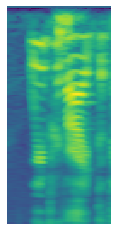

In [ ]:
crop_1000ms(original_spec).show()

In [ ]:
aud.duration

3.28

In [ ]:
original_spec.settings

SpectrogramConfig(f_min=0.0, f_max=22050.0, hop=260, n_fft=2560, n_mels=128, pad=0, to_db_scale=True, top_db=100, ws=None, n_mfcc=20)

In [ ]:
original_spec.shape

torch.Size([1, 128, 202])

In [ ]:
crop_5000ms = CropTime(5000, 16000, 260)
crop_10000ms = CropTime(10000, 16000, 260)

<class 'local.audio.core.AudioSpectrogram'>


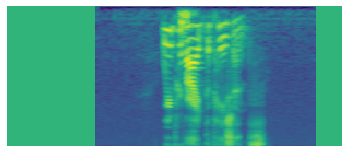

In [ ]:
crop_5000ms(original_spec).show()

<class 'local.audio.core.AudioSpectrogram'>


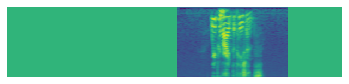

In [ ]:
crop_10000ms(original_spec).show()

<div class = "alert alert-block alert-info"> If we wanted to we could make a class for these transforms that keeps the masked portion as state so that we could write a decodes method to go back to the original</div>


<div class = "alert alert-block alert-info"> Is it better to use nonlocal here to be able to assign the value of start in the closure?</div>


### SpecAugment

In [ ]:
#export
def MaskFreq(num_masks=1, size=20, start=None, val=None, **kwargs):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Google SpecAugment time masking from https://arxiv.org/abs/1904.08779.'''
        start_ = start
        sg = spectro.clone()
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None]
        mask_val = channel_mean if val is None else val
        c, y, x = sg.shape
        for _ in range(num_masks):
            mask = torch.ones(size, x) * mask_val    
            if start_ is None: start_= random.randint(0, y-size)
            if not 0 <= start_ <= y-size:
                raise ValueError(f"Start value '{start_}' out of range for AudioSpectrogram of shape {sg.shape}")
            sg[:,start_:start_+size,:] = mask
            start_ = None
        return sg
    return _inner

In [ ]:
#export
def MaskTime(num_masks=1, size=20, start=None, val=None, **kwargs):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        sg = spectro.clone()
        sg = torch.einsum('...ij->...ji', sg)
        sg = MaskFreq(num_masks, size, start, val, **kwargs)(sg)
        return AudioSpectrogram(torch.einsum('...ij->...ji', sg))
    return _inner

In [ ]:
freq_mask = MaskFreq()

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.6 ms


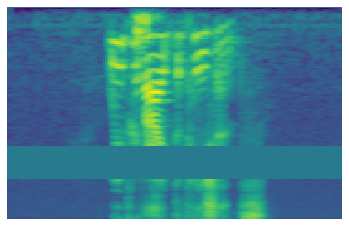

In [ ]:
%%time
freq_mask(original_spec).show()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 10.6 ms


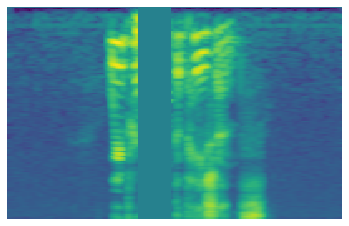

In [ ]:
%%time
time_mask = MaskTime()
time_mask(original_spec).show()

## Delta/Accelerate 

In [ ]:
#export
def _torchdelta(mel:AudioSpectrogram, order=1, width=9):
    '''Converts to numpy, takes delta and converts back to torch, needs torchification'''
    if(mel.shape[1] < width): 
        raise ValueError(f'''Delta not possible with current settings, inputs must be wider than 
        {width} columns, try setting max_to_pad to a larger value to ensure a minimum width''')
    return AudioSpectrogram(torch.from_numpy(librosa.feature.delta(mel.numpy(), order=order, width=width)))

In [ ]:
def Delta(width=9):
    td = partial(_torchdelta, width=width)
    def _inner(mel:AudioSpectrogram)->AudioSpectrogram:
        new_channels = [torch.stack([c, td(c, order=1), td(c, order=2)]) for c in mel]
        return AudioSpectrogram(torch.cat(new_channels))
    return _inner

In [ ]:
delta = Delta()

In [ ]:
d = delta(original_spec)


In [ ]:
d.shape

torch.Size([3, 128, 202])

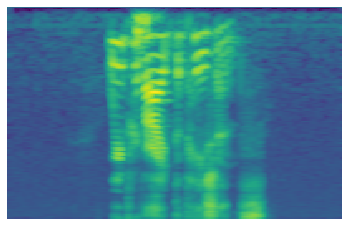

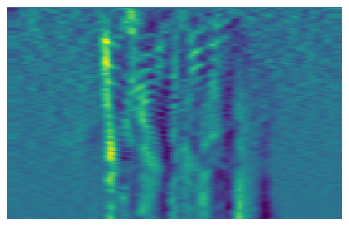

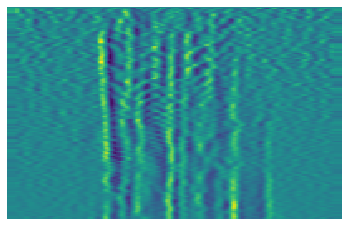

In [ ]:
for c in d: c.show()

## Pipeline testing

In [ ]:
files

(#3842) [/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00180.wav...]

In [ ]:
oa = OpenAudio(files); oa

OpenAudio: True {'object': 'encodes'} {'object': 'decodes'}

In [ ]:
sg_cfg = SpectrogramConfig(hop=256)
pipe = Pipeline([oa, AudioToSpec(settings=sg_cfg), CropTime(4000,16000,256), MaskTime(num_masks=2, size=10), MaskFreq(val=0)], as_item=True)

<class 'local.audio.core.AudioSpectrogram'>
<class 'local.audio.core.AudioSpectrogram'>
<class 'local.audio.core.AudioSpectrogram'>


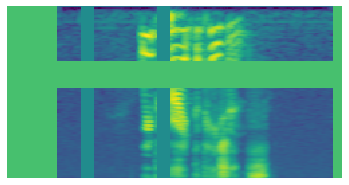

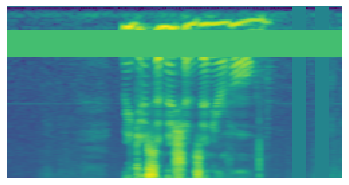

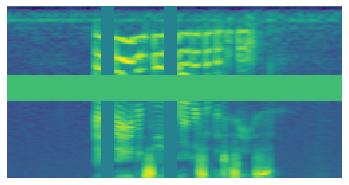

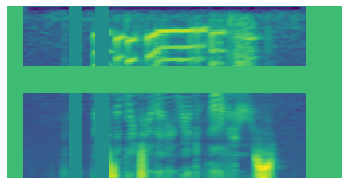

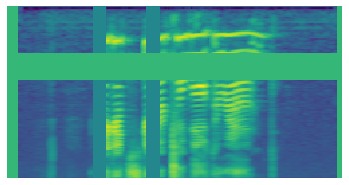

In [ ]:
for i in range(5): pipe.show(pipe(i))

## Preprocessing functions

In [ ]:
# #export
# def _merge_splits(splits, pad):
#     clip_end = splits[-1][1]
#     merged = []
#     i=0
#     while i < len(splits):
#         start = splits[i][0]
#         while splits[i][1] < clip_end and splits[i][1] + pad >= splits[i+1][0] - pad:
#             i += 1
#         end = splits[i][1]
#         merged.append(np.array([max(start-pad, 0), min(end+pad, clip_end)]))
#         i+=1
#     return np.stack(merged)

# def RemoveSilence(cfg):
#     def _inner(ai:AudioItem)->AudioItem:
#         '''Split signal at points of silence greater than 2*pad_ms '''
#         if cfg.remove_silence is None: return ai
#         padding = int(cfg.silence_padding/1000*ai.sr)
#         if(padding > ai.nsamples): return ai
#         actual = ai.sig.clone()
#         splits = split(actual.numpy(), top_db=cfg.silence_threshold, hop_length=padding)
#         if cfg.remove_silence == "split":
#             sig =  [actual[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] 
#                     for (a, b) in _merge_splits(splits, padding)]
#         elif cfg.remove_silence == "trim":
#             sig = [actual[:,(max(splits[0, 0]-padding,0)):splits[-1, -1]+padding]]
#         elif cfg.remove_silence == "all":
#             sig = [torch.cat([actual[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] 
#                               for (a, b) in _merge_splits(splits, padding)], dim=1)]
#         else: 
#             raise ValueError(f"Valid options for silence removal are None, 'split', 'trim', 'all' not '{cfg.remove_silence}'.")
#         return AudioItem((*sig, ai.sr))
#     return _inner

In [ ]:
# sg_cfg = SpectrogramConfig(hop=256)
# cfg._sr = 16000
# pipe = Pipeline([oa, RemoveSilence(cfg), AudioToSpec(cfg), MaskTime(num_masks=2, size=10), MaskFreq(val=0)], as_item=True)

In [ ]:
# for i in range(1): pipe.show(pipe(i))

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_torch_core.ipynb.
Converted 01b_script.ipynb.
Converted 01c_dataloader.ipynb.
Converted 02_data_transforms.ipynb.
Converted 03_data_pipeline.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_text_models_core.ipynb.
Converted 34_callback_rnn.ipynb.
Converted 35_tutorial_wikitext.ipynb.
Conve